# Dependencies

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# Simulation Parameters

In [29]:
N = 20                   # Number of particles
epsilon = 1.0            # Depth of the potential well
sigma = 2**(-1/6)        # Sigma controls position of minimum
r_min = sigma * 2**(1/6) # Distance where potential is minimized
L = (4 * np.pi * N / 3)**(1/3) * r_min  # Box side length
m = epsilon              # Set mass equal to epsilon for simplicity
dt = 1e-4                # Time step
T = 5                  # Temperature (in terms of epsilon) derived from: beta*epsilon = 1/5 with beta = 1/(T) as k_b is 1 in natural units
Seed = 42                # the seed for the random generators initialized for each exercise independently to ensure reproducibility for different order of execution of cells

## Plot Parameters

In [30]:
# Set font sizes globally
plt.rcParams['font.size'] = 16  # General font size
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size (xlabel, ylabel)
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 16  # Legend font size

# Functions

In [31]:


# Lennard-Jones Potential
def lj_potential(r, epsilon=1.0, sigma=2**(-1/6)):          # epsilon = 1 and sigma = 2**(-1/6) are the given values on the sheet (sigma dervied from r_min = 1)
    
    return 4 * epsilon * (np.power((sigma / r),12) - np.power((sigma / r),6))


# Lennard-Jones Force, i.e. the derivative of the potential
def lj_force(r, epsilon=1.0, sigma=2**(-1/6)):              # epsilon = 1 and sigma = 2**(-1/6) are the given values on the sheet (sigma dervied from r_min = 1)
    
    if r < 1e-12:  # Avoid division by near-zero for smaller errors
        return 0
    
    return 24 * epsilon * (2 * (sigma / r)**12 - (sigma / r)**6) / r



# Velocity-Verlet algorithm


def velocity_verlet(positions, velocities, dt):
    forces = np.zeros_like(positions)
    
    # Compute forces based on positions
    for i in range(N):
        for j in range(i + 1, N):
            # Calculate distance with periodic boundary conditions
            displacement = positions[i] - positions[j]
            displacement -= np.round(displacement / L) * L  # Minimum image convention
            r = np.linalg.norm(displacement)
            
            # Calculate force
            f = lj_force(r)
            direction = displacement / r
            forces[i] += f * direction
            forces[j] -= f * direction
    
    # Update velocities (half step)
    velocities += 0.5 * forces * dt / m
    
    # Update positions
    positions += velocities * dt
    positions %= L  # Apply periodic boundary conditions
    
    # Recompute forces based on updated positions
    forces = np.zeros_like(positions)
    for i in range(N):
        for j in range(i + 1, N):
            displacement = positions[i] - positions[j]
            displacement -= np.round(displacement / L) * L
            r = np.linalg.norm(displacement)
            f = lj_force(r)
            direction = displacement / r
            forces[i] += f * direction
            forces[j] -= f * direction
    
    # Update velocities (second half step)
    velocities += 0.5 * forces * dt / m

    return positions, velocities


# Energy calculation functions


def kinetic_energy(velocities):
    return 0.5 * m * np.sum(velocities**2)

def potential_energy(positions):
    energy = 0.0
    for i in range(N):
        for j in range(i + 1, N):
            displacement = positions[i] - positions[j]
            displacement -= np.round(displacement / L) * L
            r = np.linalg.norm(displacement)
            energy += lj_potential(r)
    return energy

def temperature(kinetic):
    return 2 * kinetic / (3 * N)  # Using k_B = 1


# Exercise 2a

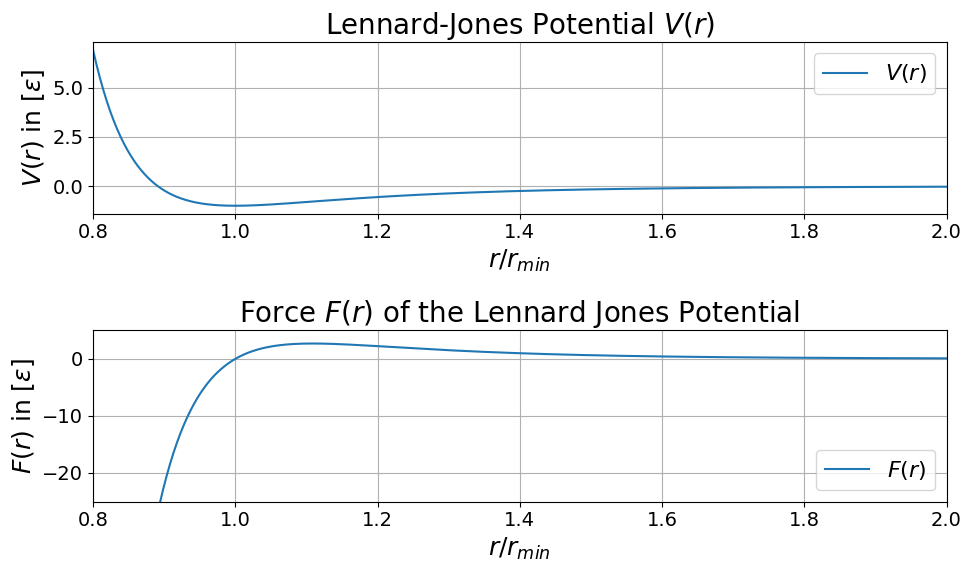

Box size (L) = 4.38 units


In [32]:
np.random.seed(Seed) # Setting seed

# Define the range for r with 0.8*r_min being the minimal distance for which we calculate
r = np.linspace(0.8*r_min, 2.0, 1000)
# Define empty arrays for potential and force
V = []
force = []
# Compute the potential and force for every position in r
for pos in r:
    V.append(lj_potential(pos,1, 2**(-1/6)))
    force.append(-lj_force(pos,1, 2**(-1/6)))


with open("Data_02/a_lennard_jones_data.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["r/r_min", "V(r)", "F(r)"])  # Write header
    writer.writerows(zip(r, V, force))  # Write data rows


# Plotting the potential and the force
plt.figure(figsize=(10, 6))

# Plot the potential
plt.subplot(2, 1, 1)
plt.plot(r, V, label=f"$V(r)$")
plt.xlabel('$r/r_{min}$')
plt.ylabel('$V(r)$ in $[\epsilon]$')
plt.xlim(r[0], r[-1])
plt.title('Lennard-Jones Potential $V(r)$')
plt.grid(True)
plt.legend()

# Plot the force (derivative of potential)
plt.subplot(2, 1, 2)
plt.plot(r, force, label="$F(r)$")
plt.xlabel('$r/r_{min}$')
plt.ylabel('$F(r)$ in [$\epsilon$]')
plt.title('Force $F(r)$ of the Lennard Jones Potential')
plt.ylim(-25,5)
plt.xlim(r[0], r[-1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Plots_02/a_lennard_jones")
plt.show()

# Print the box size
print(f"Box size (L) = {L:.2f} units")


# Exercise 2b and c

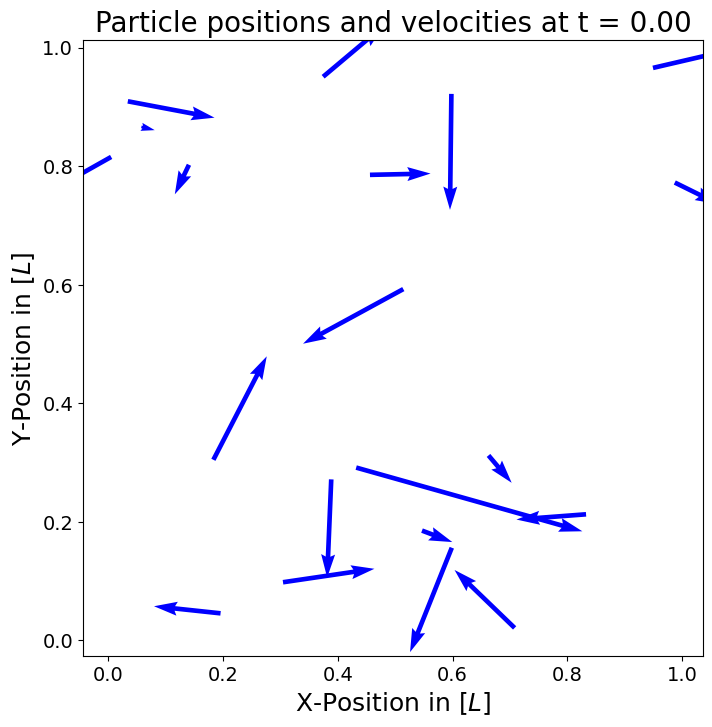

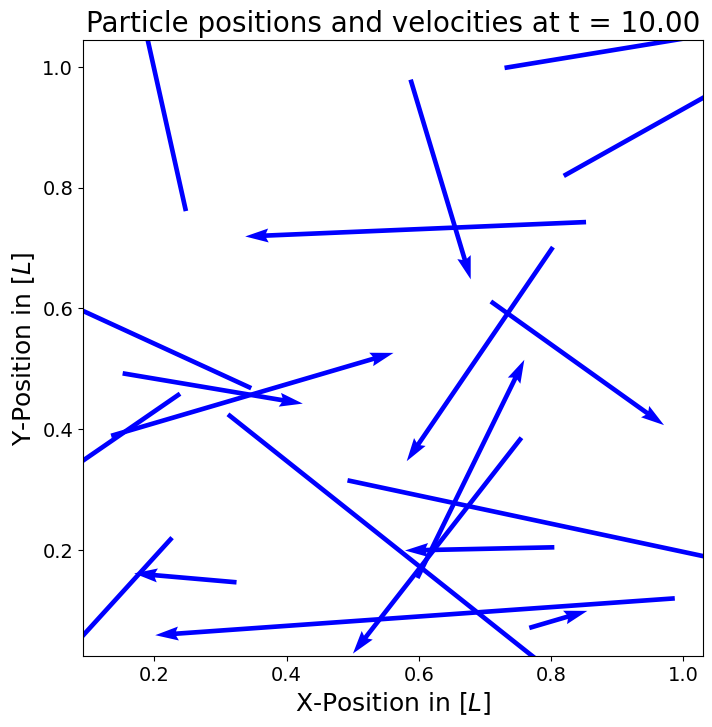

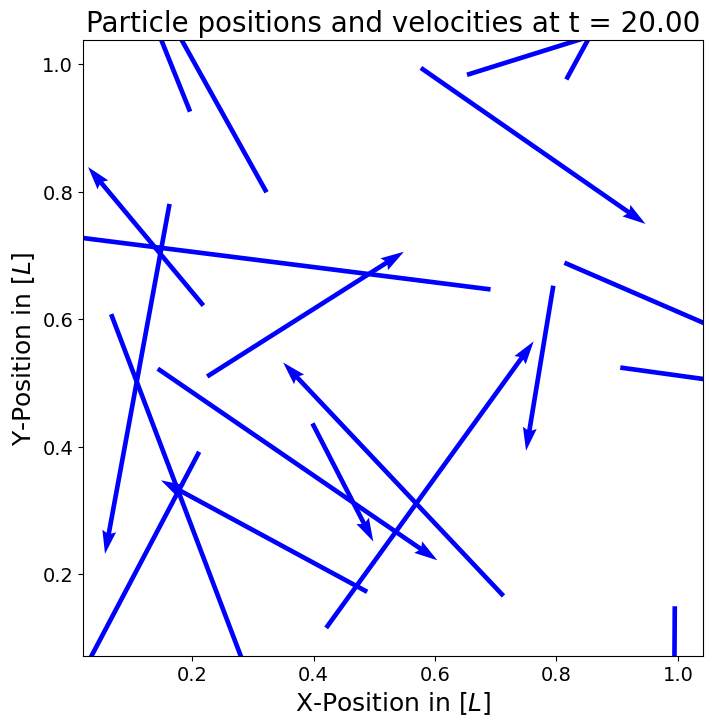

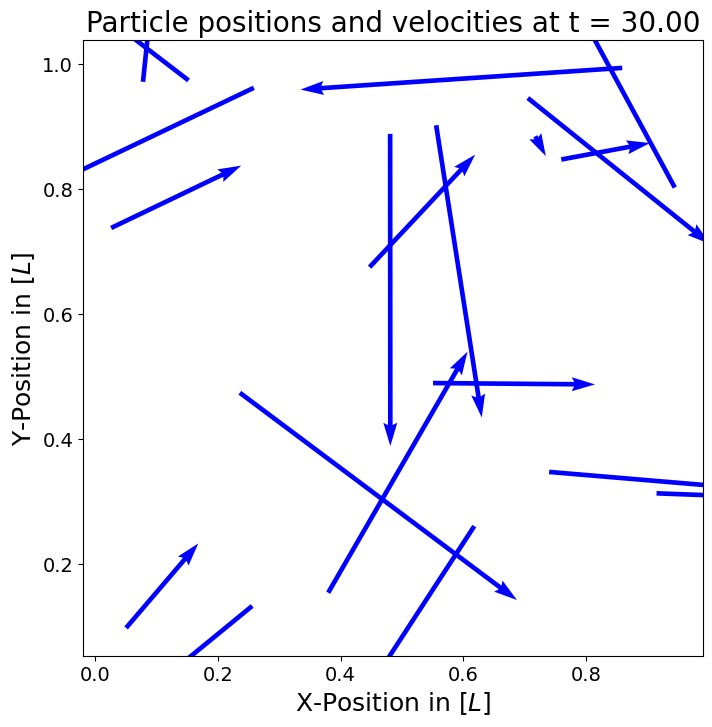

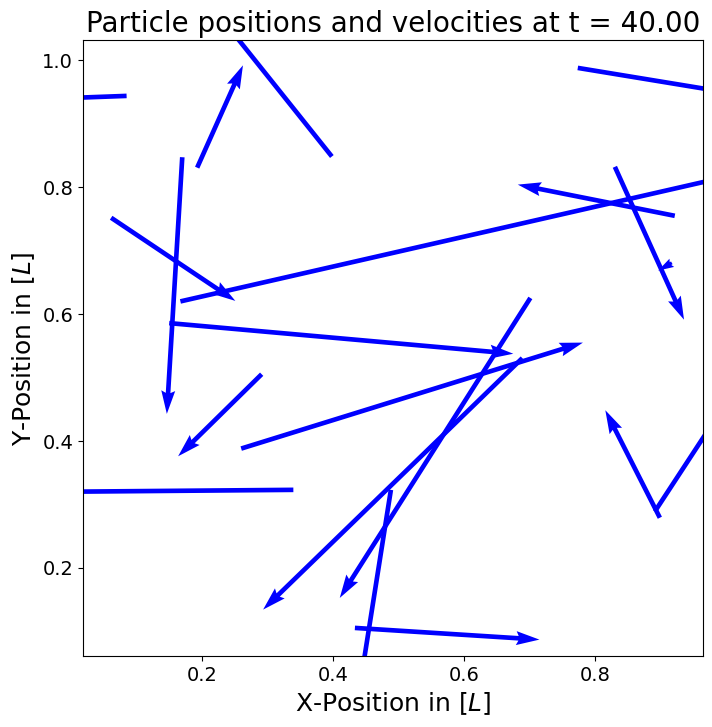

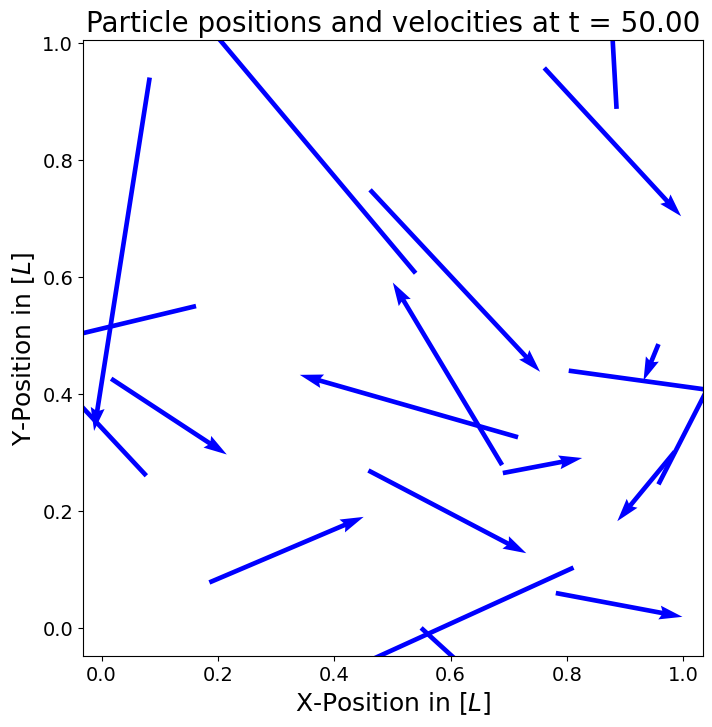

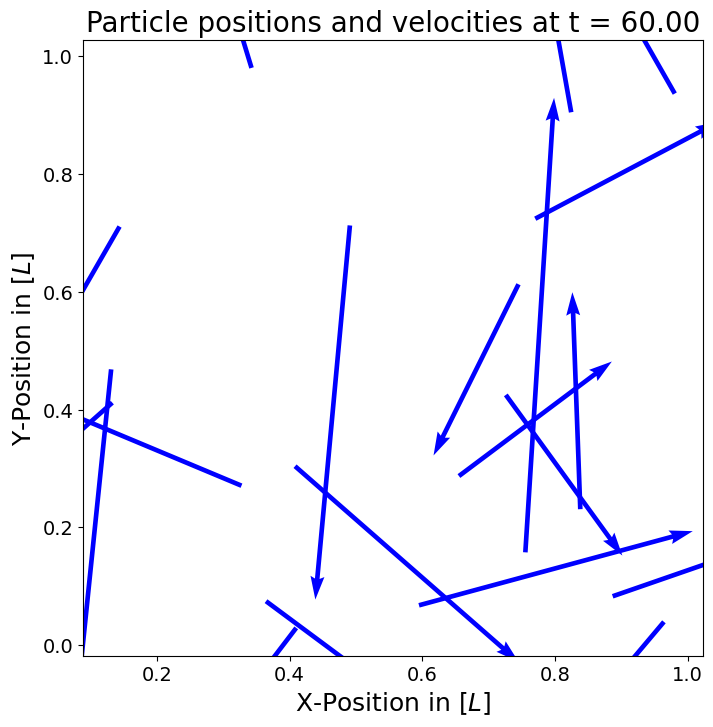

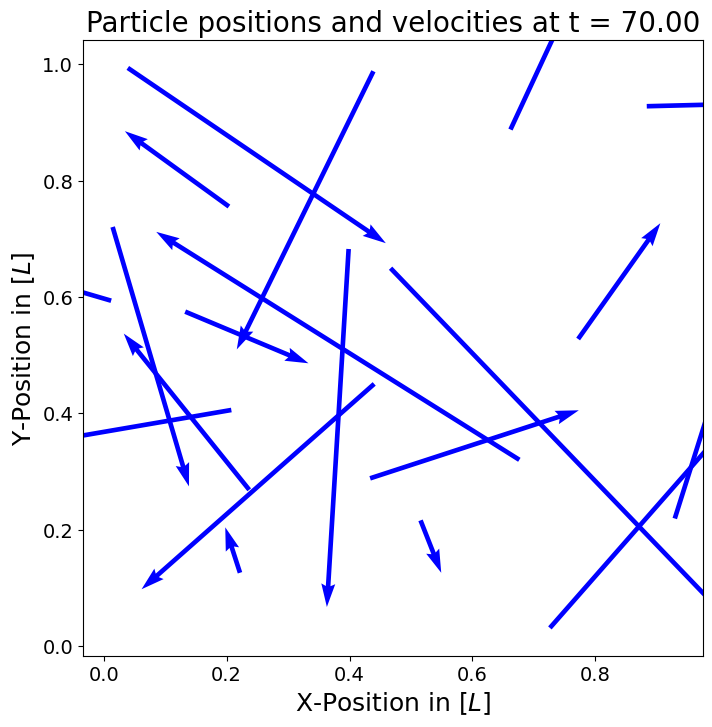

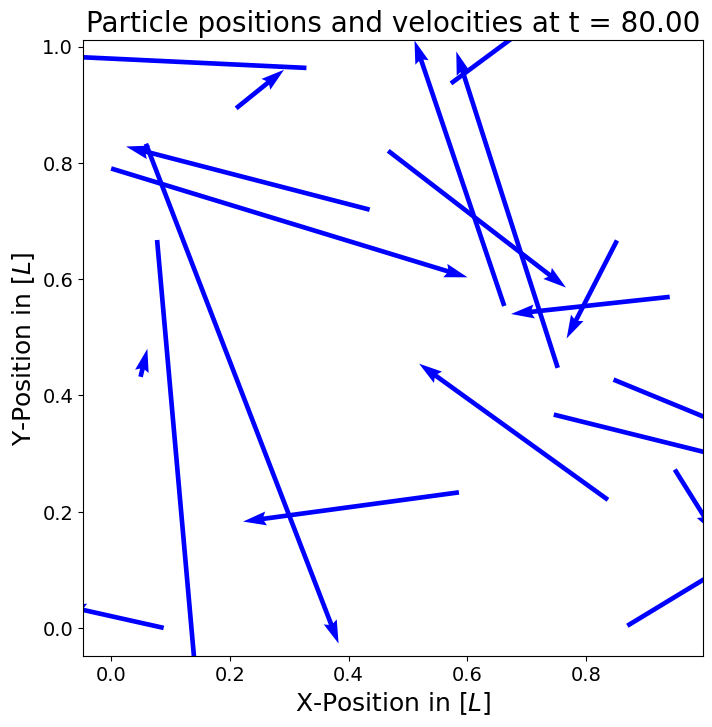

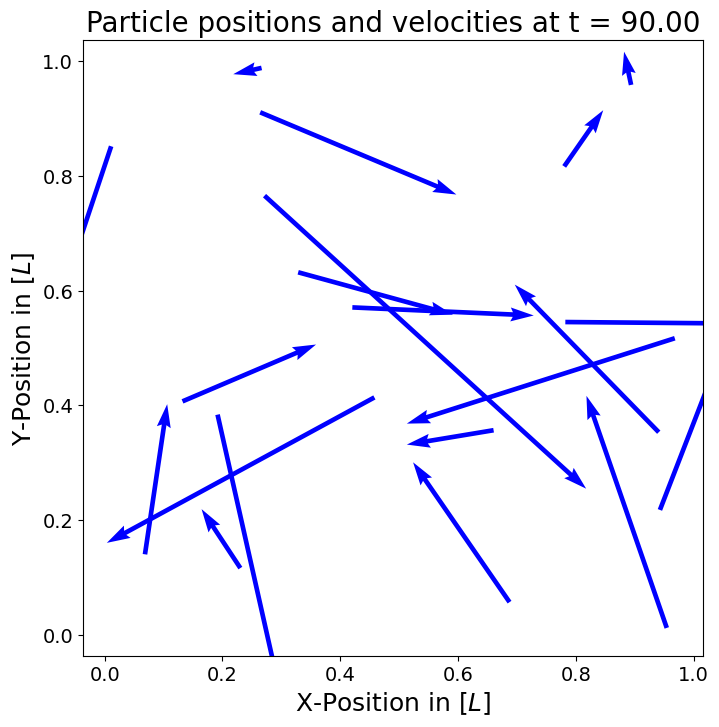

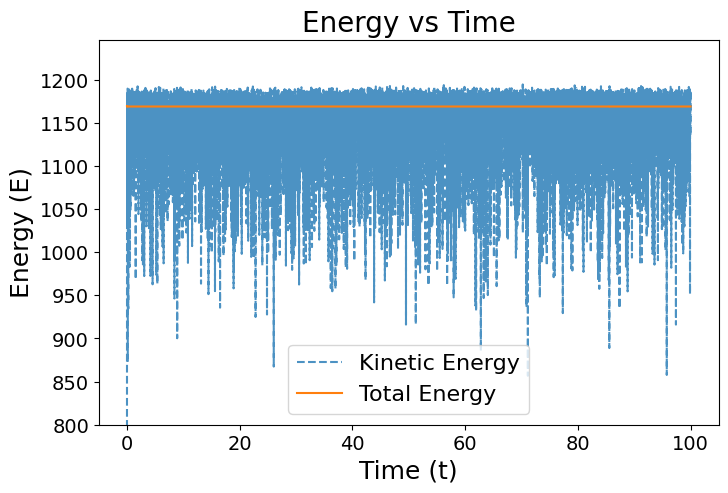

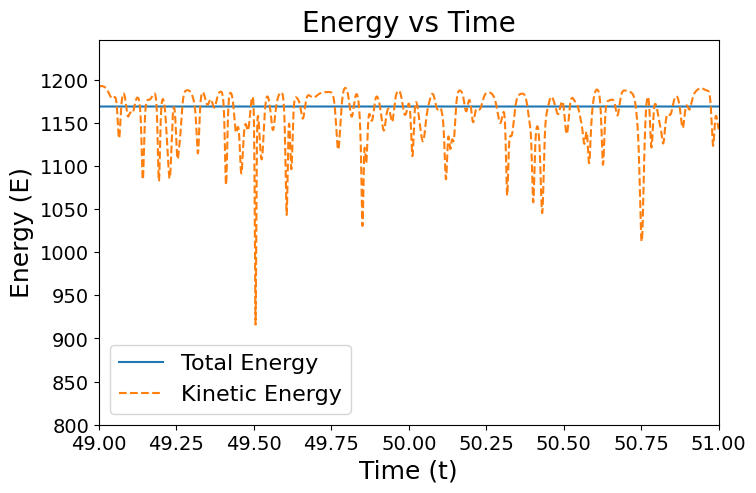

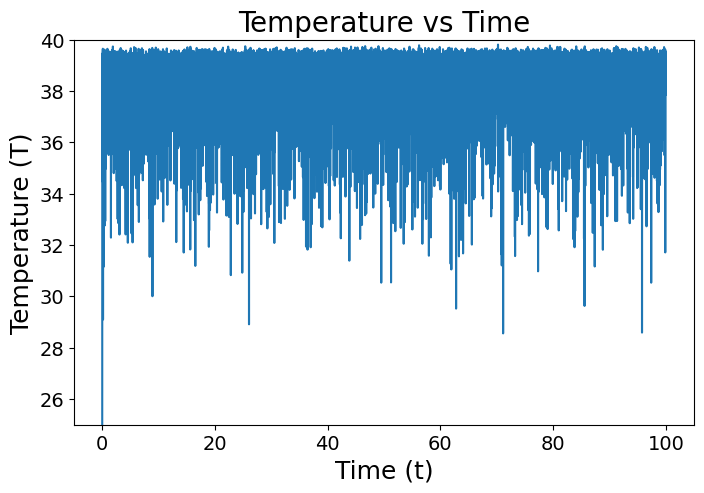

In [33]:
np.random.seed(Seed) # Setting the random seed

# Initialize positions randomly in the box
positions = np.random.uniform(0, L, (N, 3))

# Ensure particles are not too close
min_distance = 0.9 * r_min  #can be adjusted but shouldn´t be too small (approx. 0.8*r_min was given)
for i in range(N):
    for j in range(i):
        while np.linalg.norm(positions[i] - positions[j]) < min_distance:
            positions[i] = np.random.uniform(0, L, 3)


# Initialize velocities from a Maxwell-Boltzmann distribution
# For each velocity component, the distribution has a mean 0 and standard deviation sqrt(T/m)
# Since m = epsilon, we get std = sqrt(T/epsilon)
std_velocity = np.sqrt(T / epsilon)
velocities = np.random.normal(0, std_velocity, (N, 3))


# Time evolution and visualization
total_energy = []
kinetic_energies = []
temperatures = []

# Number of time steps to simulate
n_steps = 1000000

data_interval = int(n_steps/10)

for t in range(n_steps):
    positions, velocities = velocity_verlet(positions, velocities, dt)

    # Calculate energies
    ke = kinetic_energy(velocities)
    pe = potential_energy(positions)
    total_energy.append(ke + pe)
    kinetic_energies.append(ke)
    temperatures.append(temperature(ke))
    
    # Visualization every data interval
    if t % data_interval == 0:

        # normalize positions and scale velocities: 
        normalized_positions = positions / L
        scaled_velocities = velocities / L

        # Write positions to CSV
        with open(f"Data_02/Positions_{t*dt:.2f}", mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Particle', 'X', 'Y'])
            for i in range(N):
                writer.writerow([i+1] + list(normalized_positions[i]))

        # Write velocities to CSV
        with open(f"Data_02/Velocities_{t*dt:.2f}", mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Particle', 'V_x', 'V_y'])
            for i in range(N):
                writer.writerow([i+1] + list(scaled_velocities[i]))

        plt.figure(figsize=(8, 8))
        
        arrow_scale = L  # Increase this value to shrink the arrows
        plt.quiver(
            normalized_positions[:, 0], normalized_positions[:, 1],
            scaled_velocities[:, 0], scaled_velocities[:, 1],
            scale=arrow_scale, scale_units='xy', angles='xy', color='blue'
        )
        # plt.xlim(0, L)
        # plt.ylim(0, L)
        plt.xlabel("X-Position in [$L$]")
        plt.ylabel("Y-Position in [$L$]")
        plt.title(f"Particle positions and velocities at t = {t * dt:.2f}")
        plt.savefig(f"Plots_02/Positions_and_Velocities_t_{t*dt:.2f}.png")
        plt.show()



# Save energy data to CSV (Total Energy, Kinetic Energy, Potential Energy)
with open(f"Data_02/Energies_over_time", mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Time', 'Total Energy', 'Kinetic Energy'])
    for i, time_step in enumerate(np.arange(0, n_steps, data_interval)):
        writer.writerow([time_step * dt, total_energy[i], kinetic_energies[i]])

# Save temperature data to CSV
with open(f"Data_02/Temperature_over_time", mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Time', 'Temperature'])
    for i, time_step in enumerate(np.arange(0, n_steps, data_interval)):
        writer.writerow([time_step * dt, temperatures[i]])



# Plot total energy and kinetic energy
plt.figure(figsize=(8, 5))
plt.plot(np.arange(n_steps) * dt, kinetic_energies, label='Kinetic Energy', linestyle='--', alpha=0.8)
plt.plot(np.arange(n_steps) * dt, total_energy, label='Total Energy')
plt.xlabel('Time (t)')
plt.ylabel('Energy (E)')
cur_upper = plt.ylim()[1]
plt.ylim(800,cur_upper)
plt.legend()
plt.title('Energy vs Time')
plt.savefig(f"Plots_02/Energy.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(n_steps) * dt, total_energy, label='Total Energy')
plt.plot(np.arange(n_steps) * dt, kinetic_energies, label='Kinetic Energy', linestyle='--')
plt.xlabel('Time (t)')
plt.ylabel('Energy (E)')
cur_upper = plt.ylim()[1]
plt.ylim(800,cur_upper)
plt.xlim(49,51)
plt.legend()
plt.title('Energy vs Time')
plt.savefig(f"Plots_02/Energy2.png")
plt.show()

# Plot temperature evolution
plt.figure(figsize=(8, 5))
plt.plot(np.arange(n_steps) * dt, temperatures)
plt.xlabel('Time (t)')
plt.ylabel('Temperature (T)')
plt.ylim(25,40)
plt.title('Temperature vs Time')
plt.savefig(f"Plots_02/Temperature.png")
plt.show()